In [1]:
import plotly.express as px
import sklearn as sk
import pandas as pd
import numpy as np
import random
from scipy.spatial import distance

In [2]:
cars_data = pd.read_csv("../data/cars_about.csv").dropna()

In [3]:
test_id =300
user_index = actions_data[actions_data.user_id ==test_id].index.tolist()

NameError: name 'actions_data' is not defined

In [30]:
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import numpy as np

def load_and_preprocess(path:str, df:pd.DataFrame=None, scaler = StandardScaler()) -> pd.DataFrame:
    data_path = os.path.join(path,'cars_about.csv')
    data = pd.read_csv(data_path).dropna()
    data = data[data.price != "Not Priced"]

    data.price = data.price.map(lambda a: int(a.replace("$", "")))

    # binarize used_label
    data.used_label = data.used_label.apply(lambda a: int(a=="Used"))
    # split brand name from whole name of a car
    data["brand"] = data.car_model.apply(lambda a: a.split()[0])
    # remove cols because they are useful
    cars_global = data['car_id']
    data = data.drop(["car_model", "car_id"], axis=1)

    categotical_cols = [column_name for column_name in data.columns if isinstance(data[column_name].iloc[0], str)]
 
    for column in categotical_cols:
        data[column] = data[column].apply(str.lower)
        
    label_encoders = dict(zip(
        categotical_cols, [LabelEncoder().fit(data[column_name]) for column_name in categotical_cols]
    ))
    for column_name in categotical_cols:
        data[column_name] = label_encoders[column_name].transform(data[column_name])
    
    data['minMPG'] = data['minMPG'].astype('int')

    scaler = scaler.set_output(transform="pandas")
    
    data_norm = scaler.fit_transform(data)

    return data_norm


def get_item_based_reccomendation(user_path:str, datasets_path='../data/', ) -> pd.DataFrame:
    
    db_cars = load_and_preprocess(datasets_path)

    transformed_db = pd.read_csv('../data/transformed_dataset.csv')

    user_profile = pd.read_csv(os.path.join(datasets_path, user_path))
      
    user_dist = [transformed_db.iloc[int(k)].to_numpy() for k in user_profile.car_id.values]

    dist_matrix = np.stack(user_dist, axis=1)
    
    mean_dist = np.mean(dist_matrix, axis=1)
    
    
    print(transformed_db.apply(lambda x: distance.cosine(x.values, mean_dist), axis='columns').sort_values())

In [31]:
get_item_based_reccomendation("../data/liked.csv")

147    0.000111
137    0.000125
139    0.000140
154    0.000164
140    0.000168
         ...   
4      0.661954
3      0.707076
2      0.734283
1      0.770345
0      0.804823
Length: 404, dtype: float64


У меня есть действия пользователей в которые входит только информация о том лайкнул он авто или нет, мне кажется, что это довольно скупая информация. Для того чтобы диверсифицировать предпочтения сгенерированных пользователей я буду рандомно генерировать рейтинги для фильмов <br> Каким образом? <br> авто было добавлено в любимые? => random([3, 4, 5]) <br> С остальными авто поступаю иначе, генерирую для пользователя рандомное кол-во авто с низким рейтингом и уже эти авто раздаю рейтинги от 1-2

In [127]:
import os
def get_user_sparse(path:str, top_k:int=5)-> np.ndarray:
    
    actions_data = pd.read_csv(os.path.join(path, "said_to_actions.csv")).dropna().astype(int)
    user_data = pd.DataFrame(
        columns = sorted(actions_data.car_id.unique(), key=int), 
        index=actions_data.user_id.unique()
        )   
    actions_data = actions_data.astype(int)
    for user_id in actions_data.user_id:
        current_user_actions = actions_data.query(f"user_id == {user_id}")
        for car_id in current_user_actions.car_id:
            user_data[int(car_id)].iloc[user_id] = 1#random.randint(4, 5) 
    
    user_actions_sparse = user_data.fillna(0)
    test_user = pd.read_csv(os.path.join(path, "liked.csv")).car_id.astype("int").values
    test_user_sparse = np.zeros(user_actions_sparse.shape[1], dtype=np.int8)
    for i in range(test_user_sparse.shape[0]):
        test_user_sparse[i] = 1 if i in test_user else 0
        
    
        
    
    
        
    #calculate distances
    distances = np.array([np.mean([distance.yule(user_actions_sparse.iloc[i].values, test_user_sparse),
                     distance.jaccard(user_actions_sparse.iloc[i].values, test_user_sparse),
                     distance.hamming(user_actions_sparse.iloc[i].values, test_user_sparse)])
             for i in range(len(user_actions_sparse))])
    
    #merge and sort by closest neighbour
    user_sparse_dist = pd.DataFrame(distances,columns=['dist']).sort_values(by='dist').merge(user_actions_sparse, right_index=True, left_index=True)
    
    return user_sparse_dist[:top_k]

In [4]:
user_sparse_dist = get_user_sparse('../data/')

NameError: name 'get_user_sparse' is not defined

In [134]:
user_sparse_dist[user_sparse_dist.columns[1:]].sum().sort_values()

1      0
267    0
265    0
264    0
263    0
      ..
347    2
74     2
45     2
59     2
230    3
Length: 403, dtype: int64

In [12]:
# num_unique_cars = len(user_data.columns)

# for row_idx in user_data.index:
#     # specify the number of NaN values to replace with random numbers
#     # from 0 to number of non-defined cars
#     n = random.randint(0, num_unique_cars - user_data.iloc[row_idx].notna().sum())
#     # get the columns with NaN values in the specified row
#     cols_with_nans =  user_data.iloc[row_idx][ user_data.iloc[row_idx].isnull()].index.tolist()

#     # randomly fill 'n' of the NaN values in the specified row with values between 0 and 10
#     random_values = np.random.randint(1, 3, n)
#     for col in np.random.choice(cols_with_nans, n, replace=False):
#         user_data.loc[row_idx, col] = random_values[n - 1]

In [173]:
def r(x, **kwargs):
    sys.stdout.write(str(random.randint(1, 100)))

In [14]:
user_data.to_csv("../data/user_data.csv", index=False)

In [15]:
matrix = user_data.div(user_data.sum(axis=1), axis=0)


In [16]:
matrix.head()

,0,1,2,3,4,5,6,7,8,9,...,268,279,284,293,298,305,307,335,336,359
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.125
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.166667,NaN,NaN,NaN,0.166667,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.166667,NaN,0.166667,NaN,NaN,NaN,NaN,NaN,NaN
4,0.055556,0.055556,NaN,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.055556,NaN


In [17]:
users_pierson_correlation = matrix.fillna(0).T.corr()

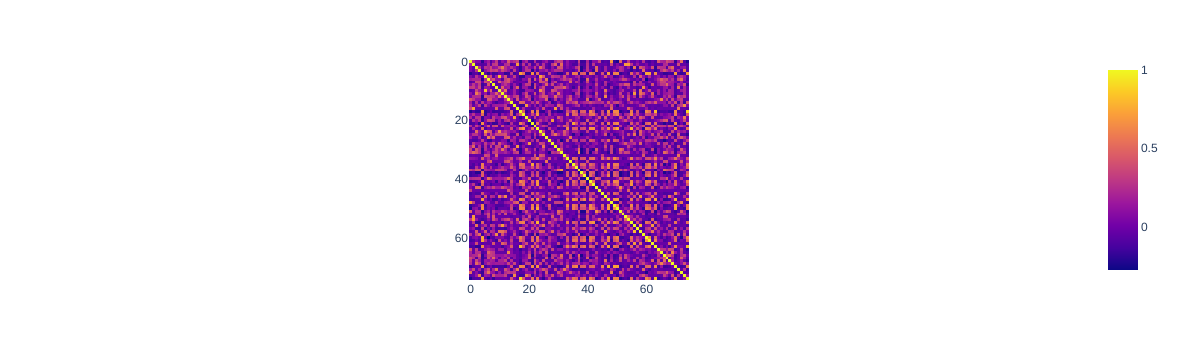

In [18]:
fig = px.imshow(users_pierson_correlation)
fig.show()

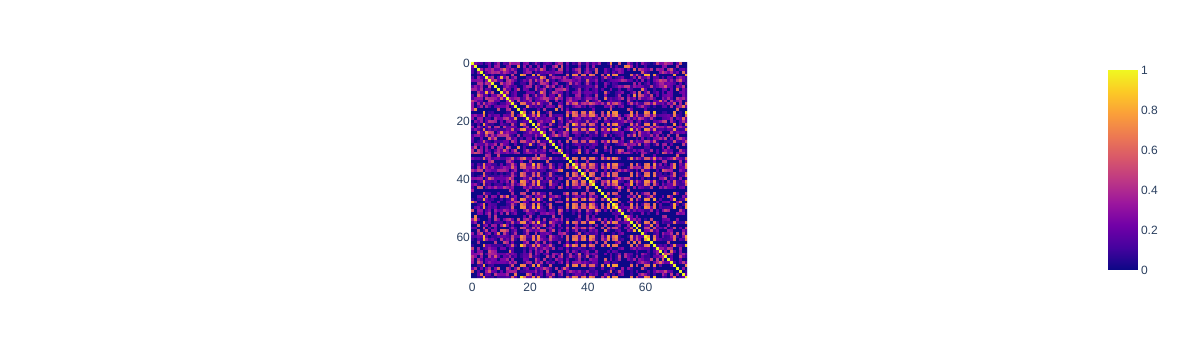

In [19]:
from sklearn.metrics.pairwise import cosine_similarity

user_cosine_similarity = cosine_similarity(matrix.fillna(0))
px.imshow(user_cosine_similarity)

In [20]:
picked_user_id = 1
users_pierson_correlation.drop(index= picked_user_id, inplace=True)
users_pierson_correlation.head()

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,74
0,1.000000,0.208549,0.051878,0.051878,-0.207670,0.051878,0.154762,-0.087070,0.076013,0.299302,...,0.208549,0.180986,0.372166,0.299302,0.250108,-0.176604,0.146578,0.532310,-0.087070,-0.230940
2,0.051878,-0.051726,1.000000,0.271795,-0.060659,0.271795,0.212022,0.364991,0.114286,0.145378,...,0.254320,0.239237,-0.092308,0.364991,0.510108,-0.023303,-0.063815,0.089744,0.145378,-0.085948
3,0.051878,-0.051726,0.271795,1.000000,-0.177059,0.089744,0.212022,0.364991,0.312197,0.364991,...,0.254320,0.409096,0.271795,0.145378,0.312197,-0.023303,0.187901,-0.092308,0.584604,-0.085948
4,-0.207670,-0.099218,-0.060659,-0.177059,1.000000,-0.060659,-0.207670,-0.001978,-0.160403,-0.142394,...,-0.099218,-0.192734,-0.177059,-0.142394,-0.160403,0.687663,-0.122407,-0.177059,-0.142394,0.686417
5,0.051878,-0.051726,0.271795,0.089744,-0.060659,1.000000,0.212022,0.364991,-0.083624,0.145378,...,-0.051726,0.069379,-0.092308,0.145378,0.114286,-0.150572,0.187901,0.271795,0.145378,-0.085948


In [21]:
top_n_users = 10
user_similarity_threshold = 0.3
similar_users = users_pierson_correlation[users_pierson_correlation[picked_user_id] > user_similarity_threshold]

In [175]:
g = list(range(10))
x = min(g)
for i in g:
    x = max(x, i)
    print(i, end='\n')
    
    
print(g)

89311001720603982652196

In [ ]:
print("п")

In [23]:
# Movies that the target user has watched
picked_userid_watched = matrix[matrix.index == picked_user_id].dropna(axis=1, how='all')
picked_userid_watched

,125,135
1,0.5,0.5


In [24]:
# Movies that similar users watched. Remove movies that none of the similar users have watched
similar_user_movies = matrix[matrix.index.isin(similar_users.index)].dropna(axis=1, how='all')
similar_user_movies

,60,65,84,92,125,126,135,142,171,184,219,279,293,335,359
9,NaN,0.25,0.25,NaN,0.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.25,NaN,NaN
16,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29,NaN,NaN,NaN,NaN,0.5,NaN,NaN,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31,0.142857,NaN,NaN,NaN,0.142857,NaN,0.142857,NaN,NaN,0.142857,0.142857,0.142857,0.142857,NaN,NaN
48,NaN,NaN,NaN,NaN,0.25,0.25,NaN,NaN,0.25,0.25,NaN,NaN,NaN,NaN,NaN
53,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54,NaN,NaN,NaN,NaN,0.25,NaN,0.25,NaN,NaN,NaN,NaN,NaN,NaN,0.25,0.25
71,NaN,0.333333,NaN,0.333333,0.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
# Remove the watched movie from the movie list
similar_user_movies.drop(picked_userid_watched.columns,axis=1, inplace=True, errors='ignore')
# Take a look at the data
similar_user_movies

,60,65,84,92,126,142,171,184,219,279,293,335,359
9,NaN,0.25,0.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.25,NaN,NaN
16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29,NaN,NaN,NaN,NaN,NaN,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31,0.142857,NaN,NaN,NaN,NaN,NaN,NaN,0.142857,0.142857,0.142857,0.142857,NaN,NaN
48,NaN,NaN,NaN,NaN,0.25,NaN,0.25,0.25,NaN,NaN,NaN,NaN,NaN
53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.25,0.25
71,NaN,0.333333,NaN,0.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
# A dictionary to store item scores
item_score = {}
# Loop through items
for i in similar_user_movies.columns:
  # Get the ratings for movie i
  movie_rating = similar_user_movies[i]
  # Create a variable to store the score
  total = 0
  # Create a variable to store the number of scores
  count = 0
  # Loop through similar users
  for u in similar_users.index:
    # If the movie has rating
    if pd.isna(movie_rating[u]) == False:
      # Score is the sum of user similarity score multiply by the movie rating
      score = similar_users[u] * movie_rating[u]
      # Add the score to the total score for the movie so far
      total += score
      # Add 1 to the count
      count +=1
  # Get the average score for the item
  item_score[i] = total / count
# Convert dictionary to pandas dataframe
item_score = pd.DataFrame(item_score.items(), columns=['movie', 'movie_score'])
    
# Sort the movies by score
ranked_item_score = item_score.sort_values(by='movie_score', ascending=False)
# Select top m movies
m = 10
ranked_item_score.head(m)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
cars_data.loc[cars_data.car_id.isin(ranked_item_score.movie) == True]

,car_id,car_model,used_label,price,exteriorColor,interiorColor,drivetrain,minMPG,maxMPG,fuelType,transmission,engine,mileage
58,60.0,Land Rover Range Rover,Used,$51,Santorini Black,Ebony / Ebony,Four-wheel Drive,14.0,19.0,Gasoline,8-Speed Automatic,5.0L V8 32V GDI DOHC Supercharged,54449.0
63,65.0,Chrysler 300 S,Used,$33,Granite Crystal Clearcoat Metallic,Linen,Rear-wheel Drive,19.0,30.0,Gasoline,8-Speed Automatic,5.7L V8 16V MPFI OHV,27054.0
82,84.0,Mercedes-Benz S-Class S 560 4MATIC,Used,$62,Black,White,All-wheel Drive,17.0,27.0,Gasoline,9-Speed Automatic,4.0L V8 32V GDI DOHC Twin Turbo,35652.0
90,92.0,Toyota Camry SE,Used,$31,Black,Black,Front-wheel Drive,28.0,39.0,Gasoline,8-Speed Automatic,2.5L I4 16V PDI DOHC,27521.0
124,126.0,Buick Enclave Essence,Used,$36,Satin Steel Metallic,Dark Galvanized,Front-wheel Drive,18.0,26.0,Gasoline,9-Speed Automatic,3.6L V6 24V GDI DOHC,29500.0
140,142.0,INFINITI QX60 Pure,Used,$31,Black Obsidian,Graphite,Front-wheel Drive,20.0,27.0,Gasoline,Automatic CVT,3.5L V6 24V GDI DOHC,48522.0
169,171.0,Acura MDX 3.5L w/Technology Package,Used,$39,Gray,Espresso,All-wheel Drive,19.0,26.0,Gasoline,9-Speed Automatic,3.5L V6 24V GDI SOHC,12304.0
182,184.0,Toyota Corolla SE,Used,$18,Blue,Black,Front-wheel Drive,31.0,40.0,Gasoline,Automatic CVT,2.0L I4 16V PDI DOHC,10514.0
217,219.0,Mercedes-Benz S-Class S 550 4MATIC,Used,$15,Blue,Brown,All-wheel Drive,14.0,20.0,Gasoline,7-Speed Automatic,5.5L V8 32V MPFI DOHC,89247.0
277,279.0,Mazda CX-5 Grand Touring,Used,$27,Jet Black Mica,Parchment,Front-wheel Drive,25.0,31.0,Gasoline,6-Speed Automatic,2.5L I4 16V GDI DOHC,37852.0
